In [1]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
import tqdm
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapz

from utils import get_LISA_norm

In [23]:
def get_LIGO_rate_uniform_e(m1, n_e_bins):
    if m1 < 20:
        rate = 20 / n_e_bins * u.Gpc**(-3) * u.yr**(-1)
    elif m1 < 50:
        rate = 4.5 / n_e_bins * u.Gpc**(-3) * u.yr**(-1)
    elif m1 < 100:
        rate = 0.2 / n_e_bins * u.Gpc**(-3) * u.yr**(-1)
        
    return rate
        
    
def get_LIGO_rate_iso_dyn(m1, e, frac_iso, ebins):
    e_circ = ebins[e < 1e-6]
    e_ecc = ebins[e >= 1e-6]
    if m1 < 20:
        if e < 1e-6:
            rate = 20 / len(e_circ) * frac_iso * u.Gpc**(-3) * u.yr**(-1)
        else:
            rate = 20 / len(e_ecc) * (1-frac_iso) * u.Gpc**(-3) * u.yr**(-1)
    elif m1 < 50:
        if e < 1e-6:
            rate = 4.5 / len(e_circ) * frac_iso * u.Gpc**(-3) * u.yr**(-1)
        else:
            rate = 4.5 / len(e_ecc) * (1-frac_iso) * u.Gpc**(-3) * u.yr**(-1)
    elif m1 < 100:
        if e < 1e-6:
            rate = 0.2 / len(e_circ) * frac_iso * u.Gpc**(-3) * u.yr**(-1)
        else:
            rate = 0.2 / len(e_ecc) * (1-frac_iso) * u.Gpc**(-3) * u.yr**(-1)
        
    return rate

In [17]:
import warnings
warnings.filterwarnings("ignore")
n_e_bins = 50
mass1_range = np.logspace(np.log10(5), np.log10(80), 50)
mass2_range = np.logspace(np.log10(5), np.log10(80), 50)
ecc_range = np.logspace(-8, -4, n_e_bins)

mass1 = []
mass2 = []
chirp_mass = []
e_LIGO = []

LISA_norms = []
times = []
ecc_evols = []
f_orb_evols = []
horizon_volumes = []

for m1 in tqdm.tqdm(mass1_range):
    for m2 in mass2_range:
        if m2 < m1:
            for e in ecc_range:
                f_orb_evol, ecc_evol, timesteps, LISA_norm = get_LISA_norm(
                    m1=m1 * u.Msun, m2=m2 * u.Msun, f_LIGO=10 * u.Hz, e_LIGO=e
                )
                ind, = np.where(f_orb_evol < 0.1 * u.Hz)
                
                #source = lw.source.Source(m_1=m1*u.Msun * np.ones_like(ecc_evol[ind]),
                #                          m_2=m2*u.Msun * np.ones_like(ecc_evol[ind]),
                #                          ecc=ecc_evol[ind],
                #                          f_orb=f_orb_evol[ind],
                #                          dist=8 * np.ones_like(ecc_evol[ind]) * u.Mpc,
                #                          interpolate_g=False,
                #                          n_proc=4,
                #                         )
                #
                #snr = source.get_snr(approximate_R=True)
                #D_h = snr/7 * 8 * u.Mpc
                #redshift = np.ones(len(D_h)) * 1e-8
                #redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
                #V_c = Planck18.comoving_volume(z=redshift)
                #horizon_volumes.append(V_c)
                mass1.append(m1)
                mass2.append(m2)
                e_LIGO.append(e)
                LISA_norms.append(LISA_norm[ind])
                times.append(timesteps[ind])
                ecc_evols.append(ecc_evol[ind])
                f_orb_evols.append(f_orb_evol[ind])
                

100%|███████████████████████████████████████████| 50/50 [10:44<00:00, 12.89s/it]


In [24]:
LIGO_rate_uniform = []
LIGO_rate_iso_dyn_50 = []
LIGO_rate_iso_dyn_80 = []

for m1 in tqdm.tqdm(mass1_range):
    for m2 in mass2_range:
        if m2 < m1:
            for e in ecc_range:
                LIGO_rate_uniform.append(get_LIGO_rate_uniform_e(m1, n_e_bins))
                LIGO_rate_iso_dyn_50.append(get_LIGO_rate_iso_dyn(m1, e, frac_iso=0.5, ebins=ecc_range))
                LIGO_rate_iso_dyn_80.append(get_LIGO_rate_iso_dyn(m1, e, frac_iso=0.8, ebins=ecc_range))
                

100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.58it/s]


In [25]:
N_lisa_tot_uniform = []
N_lisa_tot_iso_dyn_50 = []
N_lisa_tot_iso_dyn_80 = []
for ii in range(len(LISA_norms)):
    N_lisa_tot_uniform.append(trapz(f_orb_evols[ii], (LISA_norms[ii]*LIGO_rate_uniform[ii]).to(u.Mpc**(-3)*u.Hz**(-1))).value)
    N_lisa_tot_iso_dyn_50.append(trapz(f_orb_evols[ii], (LISA_norms[ii]*LIGO_rate_iso_dyn_50[ii]).to(u.Mpc**(-3)*u.Hz**(-1))).value)
    N_lisa_tot_iso_dyn_80.append(trapz(f_orb_evols[ii], (LISA_norms[ii]*LIGO_rate_iso_dyn_80[ii]).to(u.Mpc**(-3)*u.Hz**(-1))).value)

In [26]:
from matplotlib import colors

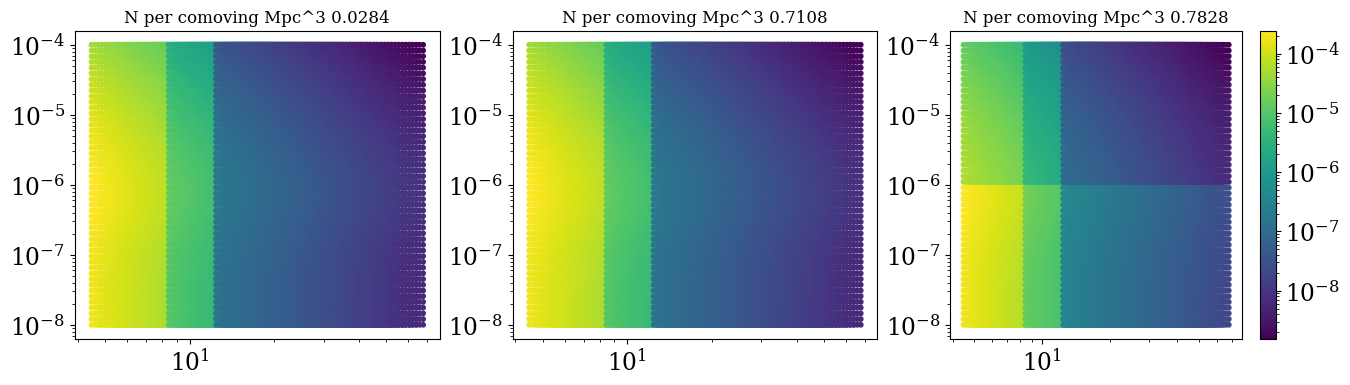

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.scatter(lw.utils.chirp_mass(mass1*u.Msun, mass2*u.Msun), e_LIGO, c=N_lisa_tot_uniform, s=10, norm=colors.LogNorm())
#print(np.sum(N_lisa_tot_uniform))
ax1.set_title(f'N per comoving Mpc^3 {np.round(np.sum(N_lisa_tot_uniform), 4)}')
ax2.scatter(lw.utils.chirp_mass(mass1*u.Msun, mass2*u.Msun), e_LIGO, c=N_lisa_tot_iso_dyn_50, s=10, norm=colors.LogNorm())
ax2.set_title(f'N per comoving Mpc^3 {np.round(np.sum(N_lisa_tot_iso_dyn_50), 4)}')
c = ax3.scatter(lw.utils.chirp_mass(mass1*u.Msun, mass2*u.Msun), e_LIGO, c=N_lisa_tot_iso_dyn_80, s=10, norm=colors.LogNorm())
ax3.set_title(f'N per comoving Mpc^3 {np.round(np.sum(N_lisa_tot_iso_dyn_80), 4)}')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

plt.colorbar(c)    